# PROYECTO FINAL CASOS DE GRIPE

# Introducción al Modelo de Predicción y Clasificación de Brotes de Gripe

En este proyecto desarrollaremos un modelo de Machine Learning híbrido enfocado en la vigilancia y análisis predictivo de la gripe estacional en Estados Unidos, integrando datos clínicos del sistema FluView y variables climáticas históricas. El modelo tiene un doble propósito:

* Objetivos:  

Predicción Continua de Casos de Gripe (num_ili y wili):
Estimamos el número esperado de casos semanales de enfermedades tipo influenza (ILI) a nivel regional, utilizando como variables predictoras tanto características clínicas como condiciones climáticas (temperatura media y aparente).

Clasificación del Riesgo de Brote:
A partir de la predicción de wili, clasificamos cada semana como riesgo bajo o alto de brote gripal, permitiendo identificar periodos críticos para la salud pública.

## 1) TRATAMIENTO DE LOS DATOS

In [1]:
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install numpy
! pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### Juntar las bases de datos FlueView y FlueView Clinical 

In [3]:
# Cargar el archivo con la informacion de salud de un CSV en un DataFrame
import pandas as pd                                         

# Cargar los archivos
df1 = pd.read_csv("/workspaces/Proyecto_Final_Salud/data/raw/fluview_data.csv")
df2 = pd.read_csv("/workspaces/Proyecto_Final_Salud/data/raw/fluview_clinical_data.csv")

# Unir los dos DataFrames en uno solo
df_combined = pd.concat([df1, df2], ignore_index=True)

In [4]:
# Diccionario de regiones HHS
hhs_regions = {
    "hhs1": "Región 1", "hhs2": "Región 2", "hhs3": "Región 3", "hhs4": "Región 4",
    "hhs5": "Región 5", "hhs6": "Región 6", "hhs7": "Región 7", "hhs8": "Región 8",
    "hhs9": "Región 9", "hhs10": "Región 10"
}

# Diccionario de estados y su región HHS
state_to_hhs = {
    "CT": "HHS1", "ME": "HHS1", "MA": "HHS1", "NH": "HHS1", "RI": "HHS1", "VT": "HHS1",
    "NJ": "HHS2", "NY": "HHS2", "PR": "HHS2", "VI": "HHS2",
    "DE": "HHS3", "DC": "HHS3", "MD": "HHS3", "PA": "HHS3", "VA": "HHS3", "WV": "HHS3",
    "AL": "HHS4", "FL": "HHS4", "GA": "HHS4", "KY": "HHS4", "MS": "HHS4", "NC": "HHS4", "SC": "HHS4", "TN": "HHS4",
    "IL": "HHS5", "IN": "HHS5", "MI": "HHS5", "MN": "HHS5", "OH": "HHS5", "WI": "HHS5",
    "AR": "HHS6", "LA": "HHS6", "NM": "HHS6", "OK": "HHS6", "TX": "HHS6",
    "IA": "HHS7", "KS": "HHS7", "MO": "HHS7", "NE": "HHS7", "KS": "HHS7",
    "CO": "HHS8", "MT": "HHS8", "ND": "HHS8", "SD": "HHS8", "UT": "HHS8", "WY": "HHS8",
    "AZ": "HHS9", "CA": "HHS9", "HI": "HHS9", "NV": "HHS9", "AS": "HHS9", "GU": "HHS9", "MP": "HHS9",
    "AK": "HHS10", "ID": "HHS10", "OR": "HHS10", "WA": "HHS10"
}

# Crear nueva columna 'Region Nombre'
df_combined["Region Nombre"] = df_combined["region"].map(hhs_regions).fillna(df_combined["region"])

# Reemplazar abreviaturas de estados con nombres completos
us_states = {
    "AZ": "Arizona", "CA": "California", "TX": "Texas", "NY": "New York", "FL": "Florida",
    "IL": "Illinois", "PA": "Pennsylvania", "OH": "Ohio", "MI": "Michigan", "GA": "Georgia",
    "NC": "North Carolina", "NJ": "New Jersey", "VA": "Virginia", "WA": "Washington", "MA": "Massachusetts",
    "IN": "Indiana", "TN": "Tennessee", "MO": "Missouri", "MD": "Maryland", "WI": "Wisconsin",
    "CO": "Colorado", "MN": "Minnesota", "SC": "South Carolina", "AL": "Alabama", "LA": "Louisiana",
    "KY": "Kentucky", "OR": "Oregon", "OK": "Oklahoma", "CT": "Connecticut", "IA": "Iowa",
    "MS": "Mississippi", "AR": "Arkansas", "UT": "Utah", "NV": "Nevada", "NM": "New Mexico",
    "WV": "West Virginia", "NE": "Nebraska", "ID": "Idaho", "HI": "Hawaii", "ME": "Maine",
    "NH": "New Hampshire", "MT": "Montana", "RI": "Rhode Island", "DE": "Delaware",
    "SD": "South Dakota", "ND": "North Dakota", "AK": "Alaska", "VT": "Vermont", "WY": "Wyoming",
    "DC": "Washington D.C.", "PR": "Puerto Rico", "VI": "Virgin Islands", "GU": "Guam", "MP": "Northern Mariana Islands",
    "AS": "American Samoa", "KS": "Kansas"
}

df_combined["Region Nombre"] = df_combined["Region Nombre"].replace(us_states)

# Crear nueva columna 'Region HHS'
df_combined["Region HHS"] = df_combined["region"].map(state_to_hhs).fillna(df_combined["region"].map(hhs_regions))

# Mostrar las primeras filas para verificar
df_combined.head()

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,...,wili,ili,total_specimens,total_a,total_b,percent_positive,percent_a,percent_b,Region Nombre,Region HHS
0,2013-12-31,hhs1,201352,201001,207,276.0,31688.0,138.0,83.0,101.0,...,0.781852,0.870992,NaN,NaN,NaN,NaN,NaN,NaN,Región 1,Región 1
1,2013-12-31,hhs10,201352,201001,207,193.0,15093.0,58.0,67.0,69.0,...,1.129034,1.278738,NaN,NaN,NaN,NaN,NaN,NaN,Región 10,Región 10
2,2013-12-31,hhs2,201352,201001,207,2342.0,109987.0,188.0,948.0,636.0,...,1.689027,2.129343,NaN,NaN,NaN,NaN,NaN,NaN,Región 2,Región 2
3,2013-12-31,hhs3,201352,201001,207,2114.0,97052.0,225.0,527.0,584.0,...,1.981594,2.178214,NaN,NaN,NaN,NaN,NaN,NaN,Región 3,Región 3
4,2013-12-31,hhs4,201352,201001,207,3052.0,145117.0,440.0,1229.0,893.0,...,1.675217,2.103131,NaN,NaN,NaN,NaN,NaN,NaN,Región 4,Región 4


In [5]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68397 entries, 0 to 68396
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   release_date      67711 non-null  object 
 1   region            68397 non-null  object 
 2   issue             68397 non-null  int64  
 3   epiweek           68397 non-null  int64  
 4   lag               68397 non-null  int64  
 5   num_ili           45341 non-null  float64
 6   num_patients      45341 non-null  float64
 7   num_providers     45341 non-null  float64
 8   num_age_0         8701 non-null   float64
 9   num_age_1         8701 non-null   float64
 10  num_age_2         0 non-null      float64
 11  num_age_3         8701 non-null   float64
 12  num_age_4         8701 non-null   float64
 13  num_age_5         8701 non-null   float64
 14  wili              45341 non-null  float64
 15  ili               45341 non-null  float64
 16  total_specimens   23056 non-null  float6

### Añadir los datos historicos de temperatura

In [6]:
# Cargar DataFrame con el historico de datos de temperatura
import pandas as pd                                         

df_temp = pd.read_csv("/workspaces/Proyecto_Final_Salud/data/raw/temperaturas_estados_usa.csv")

#Crea la columna region en df_temp
state_abbrev = {
    'Alabama': 'al', 'Alaska': 'ak', 'Arizona': 'az', 'Arkansas': 'ar',
    'California': 'ca', 'Colorado': 'co', 'Connecticut': 'ct', 'Delaware': 'de',
    'Florida': 'fl', 'Georgia': 'ga', 'Hawaii': 'hi', 'Idaho': 'id',
    'Illinois': 'il', 'Indiana': 'in', 'Iowa': 'ia', 'Kansas': 'ks',
    'Kentucky': 'ky', 'Louisiana': 'la', 'Maine': 'me', 'Maryland': 'md',
    'Massachusetts': 'ma', 'Michigan': 'mi', 'Minnesota': 'mn', 'Mississippi': 'ms',
    'Missouri': 'mo', 'Montana': 'mt', 'Nebraska': 'ne', 'Nevada': 'nv',
    'New Hampshire': 'nh', 'New Jersey': 'nj', 'New Mexico': 'nm', 'New York': 'ny',
    'North Carolina': 'nc', 'North Dakota': 'nd', 'Ohio': 'oh', 'Oklahoma': 'ok',
    'Oregon': 'or', 'Pennsylvania': 'pa', 'Rhode Island': 'ri', 'South Carolina': 'sc',
    'South Dakota': 'sd', 'Tennessee': 'tn', 'Texas': 'tx', 'Utah': 'ut',
    'Vermont': 'vt', 'Virginia': 'va', 'Washington': 'wa', 'West Virginia': 'wv',
    'Wisconsin': 'wi', 'Wyoming': 'wy','Kansas': 'ks'
}

df_temp["region"] = df_temp["Estado"].map(state_abbrev)
df_temp.rename(columns={"year_week": "epiweek"}, inplace=True)



In [7]:
df_merged = pd.merge(df_combined, df_temp, how="left", on=["region", "epiweek"])

In [8]:
df_merged.to_csv('../data/raw/df_merged.csv', index=False)

In [9]:
import pandas as pd

# Cargar el archivo combinado
df = pd.read_csv('../data/raw/df_merged.csv', delimiter=',', encoding='utf-8')

# Vista general
print(df.shape)

df.info()

(68397, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68397 entries, 0 to 68396
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   release_date               67711 non-null  object 
 1   region                     68397 non-null  object 
 2   issue                      68397 non-null  int64  
 3   epiweek                    68397 non-null  int64  
 4   lag                        68397 non-null  int64  
 5   num_ili                    45341 non-null  float64
 6   num_patients               45341 non-null  float64
 7   num_providers              45341 non-null  float64
 8   num_age_0                  8701 non-null   float64
 9   num_age_1                  8701 non-null   float64
 10  num_age_2                  0 non-null      float64
 11  num_age_3                  8701 non-null   float64
 12  num_age_4                  8701 non-null   float64
 13  num_age_5                  8701 no

In [10]:
df.head()

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,...,total_a,total_b,percent_positive,percent_a,percent_b,Region Nombre,Region HHS,Estado,temperature_2m_mean,apparent_temperature_mean
0,2013-12-31,hhs1,201352,201001,207,276.0,31688.0,138.0,83.0,101.0,...,NaN,NaN,NaN,NaN,NaN,Región 1,Región 1,NaN,NaN,NaN
1,2013-12-31,hhs10,201352,201001,207,193.0,15093.0,58.0,67.0,69.0,...,NaN,NaN,NaN,NaN,NaN,Región 10,Región 10,NaN,NaN,NaN
2,2013-12-31,hhs2,201352,201001,207,2342.0,109987.0,188.0,948.0,636.0,...,NaN,NaN,NaN,NaN,NaN,Región 2,Región 2,NaN,NaN,NaN
3,2013-12-31,hhs3,201352,201001,207,2114.0,97052.0,225.0,527.0,584.0,...,NaN,NaN,NaN,NaN,NaN,Región 3,Región 3,NaN,NaN,NaN
4,2013-12-31,hhs4,201352,201001,207,3052.0,145117.0,440.0,1229.0,893.0,...,NaN,NaN,NaN,NaN,NaN,Región 4,Región 4,NaN,NaN,NaN


# 2) ANALISIS EXPLORATORIO DE DATOS (EDA)

## Identificar los valores nulos

In [11]:
# Porcentaje de nulos por columna
nulls = df.isnull().mean().sort_values(ascending=False)
print(nulls[nulls > 0])  # solo columnas con nulos

num_age_2                    1.000000
num_age_0                    0.872787
num_age_1                    0.872787
num_age_4                    0.872787
num_age_5                    0.872787
num_age_3                    0.872787
Region HHS                   0.819875
total_specimens              0.662909
percent_positive             0.662909
total_a                      0.662909
total_b                      0.662909
percent_b                    0.662909
percent_a                    0.662909
ili                          0.337091
wili                         0.337091
num_providers                0.337091
num_patients                 0.337091
num_ili                      0.337091
temperature_2m_mean          0.207860
apparent_temperature_mean    0.207860
Estado                       0.207860
release_date                 0.010030
dtype: float64


In [12]:
# Eliminar columnas vacias
df = df.drop ('num_age_2', axis = 1)
df = df.rename(columns={
    "Estado": "state"
})

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68397 entries, 0 to 68396
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   release_date               67711 non-null  object 
 1   region                     68397 non-null  object 
 2   issue                      68397 non-null  int64  
 3   epiweek                    68397 non-null  int64  
 4   lag                        68397 non-null  int64  
 5   num_ili                    45341 non-null  float64
 6   num_patients               45341 non-null  float64
 7   num_providers              45341 non-null  float64
 8   num_age_0                  8701 non-null   float64
 9   num_age_1                  8701 non-null   float64
 10  num_age_3                  8701 non-null   float64
 11  num_age_4                  8701 non-null   float64
 12  num_age_5                  8701 non-null   float64
 13  wili                       45341 non-null  flo

In [14]:
# Filtrar filas en las que el valor de la columna "region" es distinto al valor de la columna "state":
mismatched_states = df[df["region"] != df["state"]]
print(mismatched_states[["region", "state"]])

      region state
0       hhs1   NaN
1      hhs10   NaN
2       hhs2   NaN
3       hhs3   NaN
4       hhs4   NaN
...      ...   ...
68392     vt   NaN
68393     wa   NaN
68394     wi   NaN
68395     wv   NaN
68396     wy   NaN

[68397 rows x 2 columns]


In [15]:
# Reemplazar los valores nulos de la columna «estado» por los valores de la columna «región».
df["state"] = df["state"].fillna(df["region"])
df["state"] = df["state"].str.upper()

# Rellenar las abreviaturas de los estados con nombres completos
df["state"] = df["state"].replace(us_states)
df["state"] = df["state"].str.lower()
df["region"] = df["region"].str.lower()

In [16]:
#  Eliminar las filas con valores nulos en 'state' or 'region'
regions = ['hhs1', 'hhs10', 'hhs2', 'hhs3', 'hhs4', 'hhs5', 'hhs6', 'hhs7', 'hhs8', 'hhs9', 'nat']
df = df[~df["state"].isin(regions)]
df = df[~df["region"].isin(regions)]

In [17]:
#devuelve array con los valores únicos que aparecen en la columna region del DataFrame df
df.region.unique()

array(['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'ga', 'hi', 'ia',
       'id', 'il', 'in', 'ks', 'ky', 'ma', 'md', 'me', 'mi', 'mn', 'mo',
       'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'oh', 'ok',
       'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa',
       'wi', 'wv', 'wy', 'ny', 'la', 'fl'], dtype=object)

In [18]:
#devuelve array con los valores únicos que aparecen en la columna state del DataFrame df

df.state.unique()

array(['alaska', 'alabama', 'arkansas', 'arizona', 'california',
       'colorado', 'connecticut', 'delaware', 'georgia', 'hawaii', 'iowa',
       'idaho', 'illinois', 'indiana', 'kansas', 'kentucky',
       'massachusetts', 'maryland', 'maine', 'michigan', 'minnesota',
       'missouri', 'mississippi', 'montana', 'north carolina',
       'north dakota', 'nebraska', 'new hampshire', 'new jersey',
       'new mexico', 'nevada', 'ohio', 'oklahoma', 'oregon',
       'pennsylvania', 'rhode island', 'south carolina', 'south dakota',
       'tennessee', 'texas', 'utah', 'virginia', 'vermont', 'washington',
       'wisconsin', 'west virginia', 'wyoming', 'new york', 'louisiana',
       'florida'], dtype=object)

In [19]:
# Eliminar columnas innecesarias
df = df.drop(columns=["num_age_0", "num_age_1", "num_age_3", "num_age_4", "num_age_5", "region", "Region HHS"], axis=1)

In [20]:
# Revisar valores nulos en la columna de Temperature
missing_states = df[df["temperature_2m_mean"].isna() & df["apparent_temperature_mean"].isna()]["state"].unique()
print("[INFO] States with missing temperature data:", missing_states)


[INFO] States with missing temperature data: ['alaska' 'alabama' 'arkansas' 'arizona' 'california' 'colorado'
 'connecticut' 'delaware' 'florida' 'georgia' 'hawaii' 'iowa' 'idaho'
 'illinois' 'indiana' 'kansas' 'kentucky' 'louisiana' 'massachusetts'
 'maryland' 'maine' 'michigan' 'minnesota' 'missouri' 'mississippi'
 'montana' 'north carolina' 'north dakota' 'nebraska' 'new hampshire'
 'new jersey' 'new mexico' 'nevada' 'ohio' 'oklahoma' 'oregon'
 'pennsylvania' 'rhode island' 'south carolina' 'south dakota' 'tennessee'
 'texas' 'utah' 'virginia' 'washington' 'wisconsin' 'west virginia'
 'wyoming' 'vermont']


In [21]:
# Rellenar los valores de temperatura media que faltan por estado
df["temperature_2m_mean"] = df.groupby("state")["temperature_2m_mean"].transform(
    lambda x: x.fillna(x.mean())
)
# Rellenar los valores de apparent temperature que faltan por estado
df["apparent_temperature_mean"] = df.groupby("state")["apparent_temperature_mean"].transform(
    lambda x: x.fillna(x.mean())
)
# Revisar si quedan valores nulos
print(df[["temperature_2m_mean", "apparent_temperature_mean"]].isna().sum())


temperature_2m_mean          0
apparent_temperature_mean    0
dtype: int64


In [22]:
missing_states = df[df["temperature_2m_mean"].isna() & df["apparent_temperature_mean"].isna()]["state"].unique()
print("[INFO] States with missing temperature data:", missing_states)

[INFO] States with missing temperature data: []


In [23]:
import pandas as pd

# Lista de regiones
regiones = ['hhs1', 'hhs10', 'hhs2', 'hhs3', 'hhs4', 'hhs5', 'hhs6', 'hhs7', 'hhs8', 'hhs9', 'nat']
df_filtrado = df[df['state'].isin(regiones)]
conteo_regiones = df_filtrado['state'].value_counts().sort_index()
tabla_conteo = pd.DataFrame({
    'state': conteo_regiones.index,
    'count': conteo_regiones.values
})

print(tabla_conteo)

Empty DataFrame
Columns: [state, count]
Index: []


In [24]:
# Lista de estados a eliminar
estados_a_eliminar = ['hhs1', 'hhs10', 'hhs2', 'hhs3', 'hhs4', 'hhs5', 'hhs6', 'hhs7', 'hhs8', 'hhs9', 'nat']

# Filtrar el DataFrame para que solo retenga las filas cuyo estado NO esté en la lista
df = df[~df['state'].isin(estados_a_eliminar)]

# Verifica que las filas han sido eliminadas
print(df['state'].unique())

['alaska' 'alabama' 'arkansas' 'arizona' 'california' 'colorado'
 'connecticut' 'delaware' 'georgia' 'hawaii' 'iowa' 'idaho' 'illinois'
 'indiana' 'kansas' 'kentucky' 'massachusetts' 'maryland' 'maine'
 'michigan' 'minnesota' 'missouri' 'mississippi' 'montana'
 'north carolina' 'north dakota' 'nebraska' 'new hampshire' 'new jersey'
 'new mexico' 'nevada' 'ohio' 'oklahoma' 'oregon' 'pennsylvania'
 'rhode island' 'south carolina' 'south dakota' 'tennessee' 'texas' 'utah'
 'virginia' 'vermont' 'washington' 'wisconsin' 'west virginia' 'wyoming'
 'new york' 'louisiana' 'florida']


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54845 entries, 429 to 68396
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   release_date               54159 non-null  object 
 1   issue                      54845 non-null  int64  
 2   epiweek                    54845 non-null  int64  
 3   lag                        54845 non-null  int64  
 4   num_ili                    36640 non-null  float64
 5   num_patients               36640 non-null  float64
 6   num_providers              36640 non-null  float64
 7   wili                       36640 non-null  float64
 8   ili                        36640 non-null  float64
 9   total_specimens            18205 non-null  float64
 10  total_a                    18205 non-null  float64
 11  total_b                    18205 non-null  float64
 12  percent_positive           18205 non-null  float64
 13  percent_a                  18205 non-null  float6

In [26]:
df.to_csv('../data/raw/df_final.csv', index=False)

En la limpieza del dataframe hemos realizado los siguientes pasos:  

* Eliminamos directamene la columna num_age_2, dado a que estaba completamente vacia y no era de utilidad
* Las columnas "num_age_0", "num_age_1", "num_age_3", "num_age_4", "num_age_5", "region", "Region HHS"; aunque quisimos tenerlas en cuenta para el analisis en un principio, dado a que esta informacion estaba agrupada por regiones y no por cada uno de los estados debimos prescindir de esta información.  
* Asi mismo las filas correspondientes a los datos agrupados por regiones('hhs1', 'hhs10', 'hhs2', 'hhs3', 'hhs4', 'hhs5', 'hhs6', 'hhs7', 'hhs8', 'hhs9', 'nat') fueron eliminados del dataframe dado que el análisis por regiones no es viable en este caso. 

## Distribución de variables clave

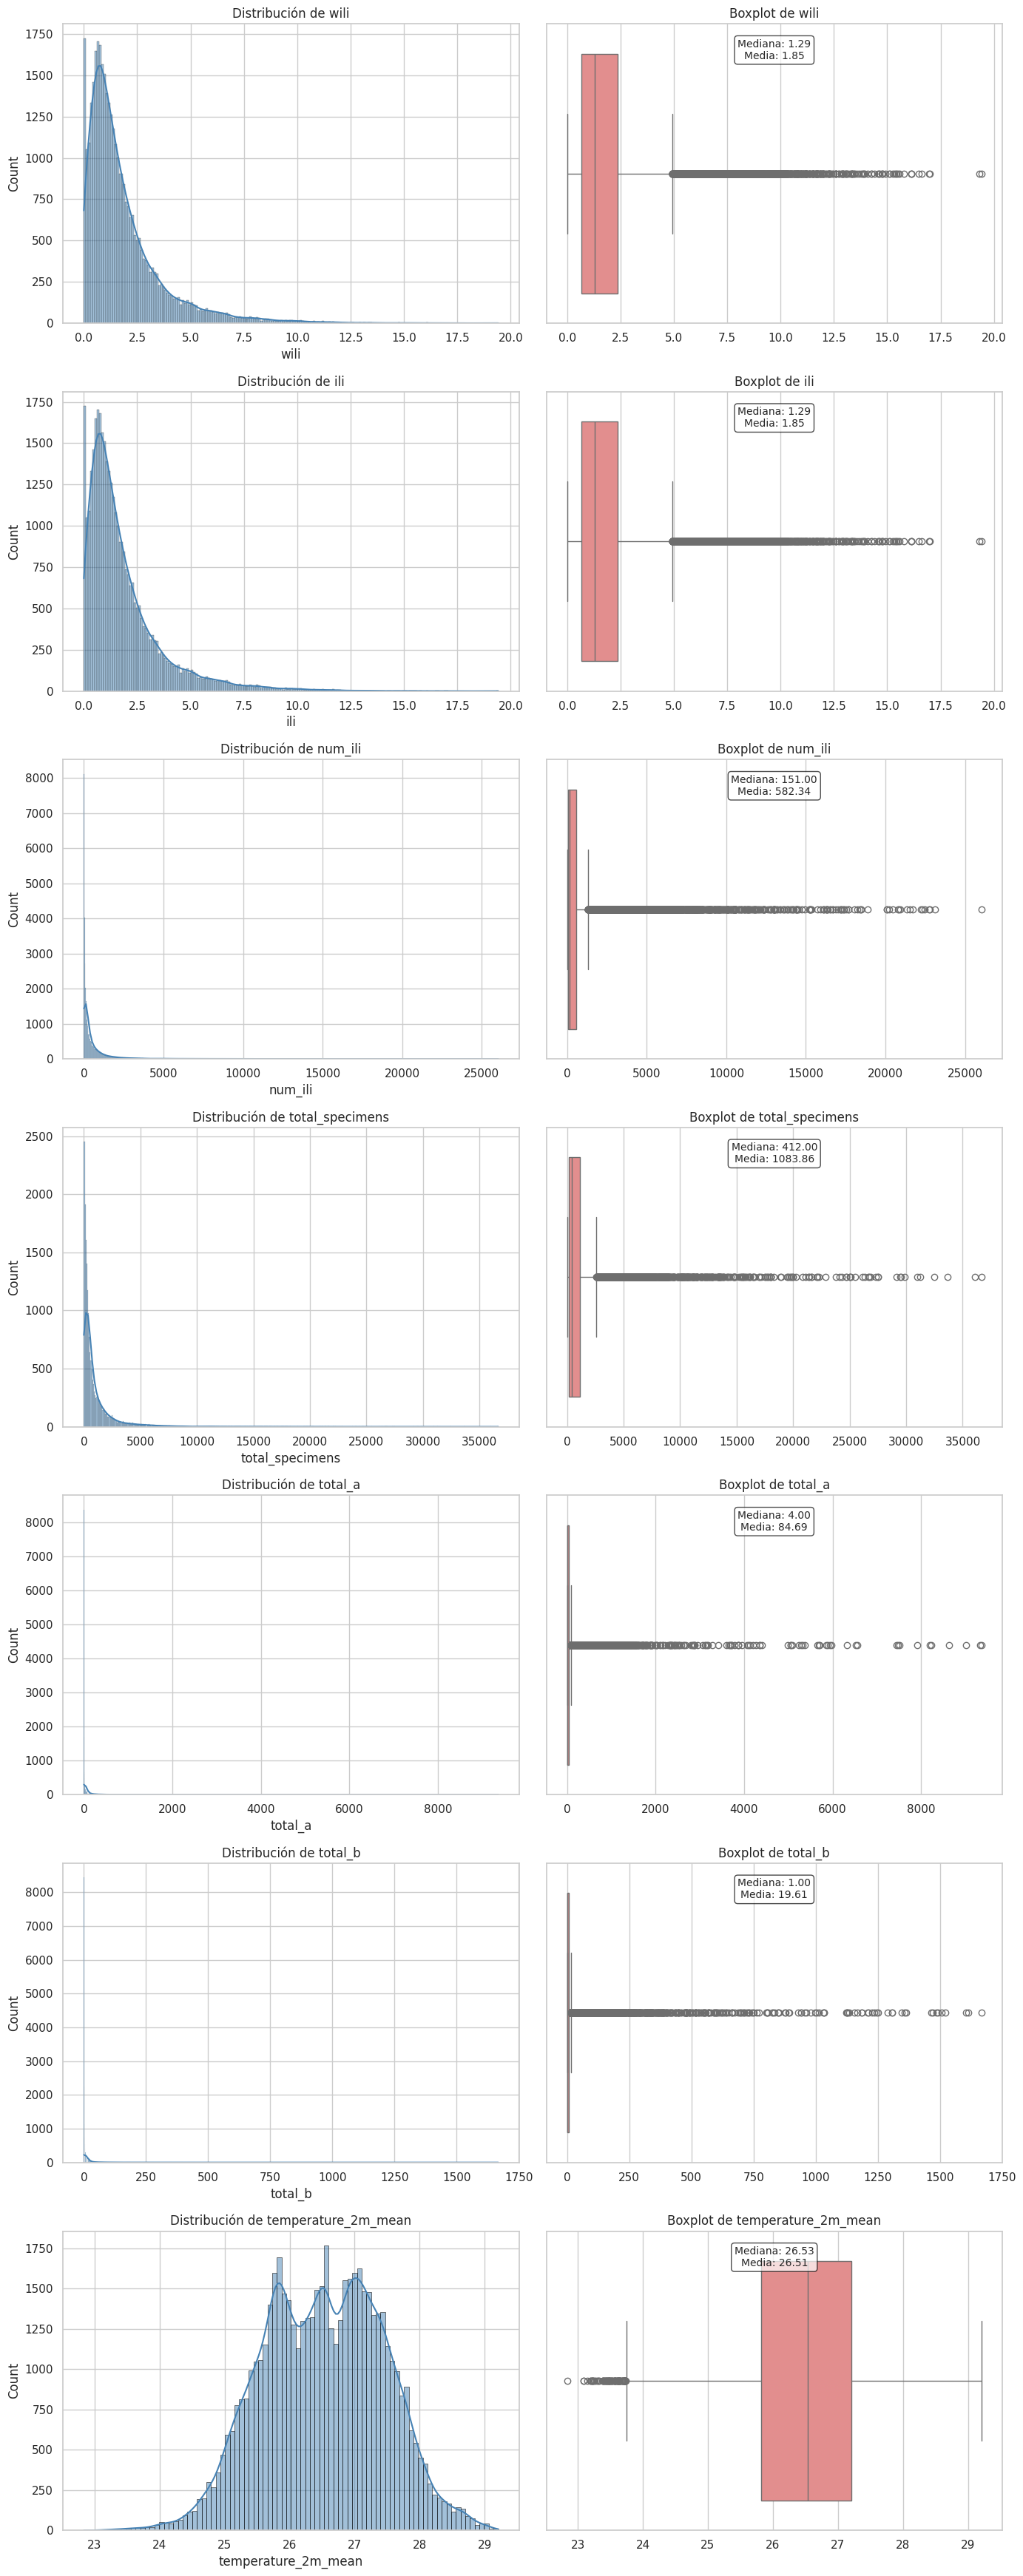

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Seleccionamos solo las variables numéricas que nos interesan:
numeric_features = ['wili', 'ili', 'num_ili', 'total_specimens', 'total_a', 'total_b', 'temperature_2m_mean']

# Creamos el DataFrame filtrado solo con estas columnas
df_numeric = df[numeric_features]

# Parámetros de visualización global 
sns.set(style="whitegrid")  # Estilo de fondo de Seaborn

# Figura con 2 subplots por variable
fig, ax = plt.subplots(len(numeric_features), 2, figsize=(14, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Histograma + KDE
    sns.histplot(data=df_numeric, x=feature, kde=True, ax=ax[i, 0], color='steelblue', edgecolor='black')
    ax[i, 0].set_title(f"Distribución de {feature}", fontsize=12)
    ax[i, 0].set_xlabel(feature)
    
    # Boxplot
    sns.boxplot(data=df_numeric, x=feature, ax=ax[i, 1], color='lightcoral')
    ax[i, 1].set_title(f"Boxplot de {feature}", fontsize=12)
    ax[i, 1].set_xlabel(None)
    
    # anotar estadísticos básicos en el boxplot
    median_value = df_numeric[feature].median()
    mean_value = df_numeric[feature].mean()
    ax[i, 1].annotate(f"Mediana: {median_value:.2f}\nMedia: {mean_value:.2f}", 
                      xy=(0.5, 0.95), xycoords='axes fraction',
                      ha='center', va='top', fontsize=10,
                      bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

plt.tight_layout()
plt.show()

El gráfico muestra la distribución de la variable wili, que representa el porcentaje ponderado de visitas por enfermedades similares a la gripe (Influenza-Like Illness, ILI) en clínicas de EE.UU.

* Distribución sesgada a la derecha
* La mayoría de los valores de wili están concentrados entre 0 y 2.5.
* Hay una cola larga hacia la derecha, indicando que en algunos casos se han registrado valores más altos de incidencia de gripe.
* Esto sugiere que la gripe suele mantenerse en niveles bajos, con algunos picos de mayor incidencia en ciertas semanas.
* Los outliers indican semanas con actividad gripal inusualmente alta (probables brotes).

Total de pruebas de laboratorio:  
* Sesgada a la derecha, y alta concentración de valores por debajo de 5,000, con casos extremos llegando a +35,000.
* Las semanas con más pruebas pueden coincidir con campañas de vigilancia reforzada o temporadas de alta circulación viral.


Análisis del gráfico de Distribución de la Temperatura Media: 

* En contraste, la temperatura media sigue una distribución más normal y simétrica con una ligera tendencia bimodal.
* La temperatura oscila principalmente entre 24°C y 29°C, con una mayor frecuencia alrededor de los 26-27°C.
* Esto indica que la variabilidad de la temperatura es más controlada en comparación con wili, que tiene una mayor dispersión.

## Variables Numéricas

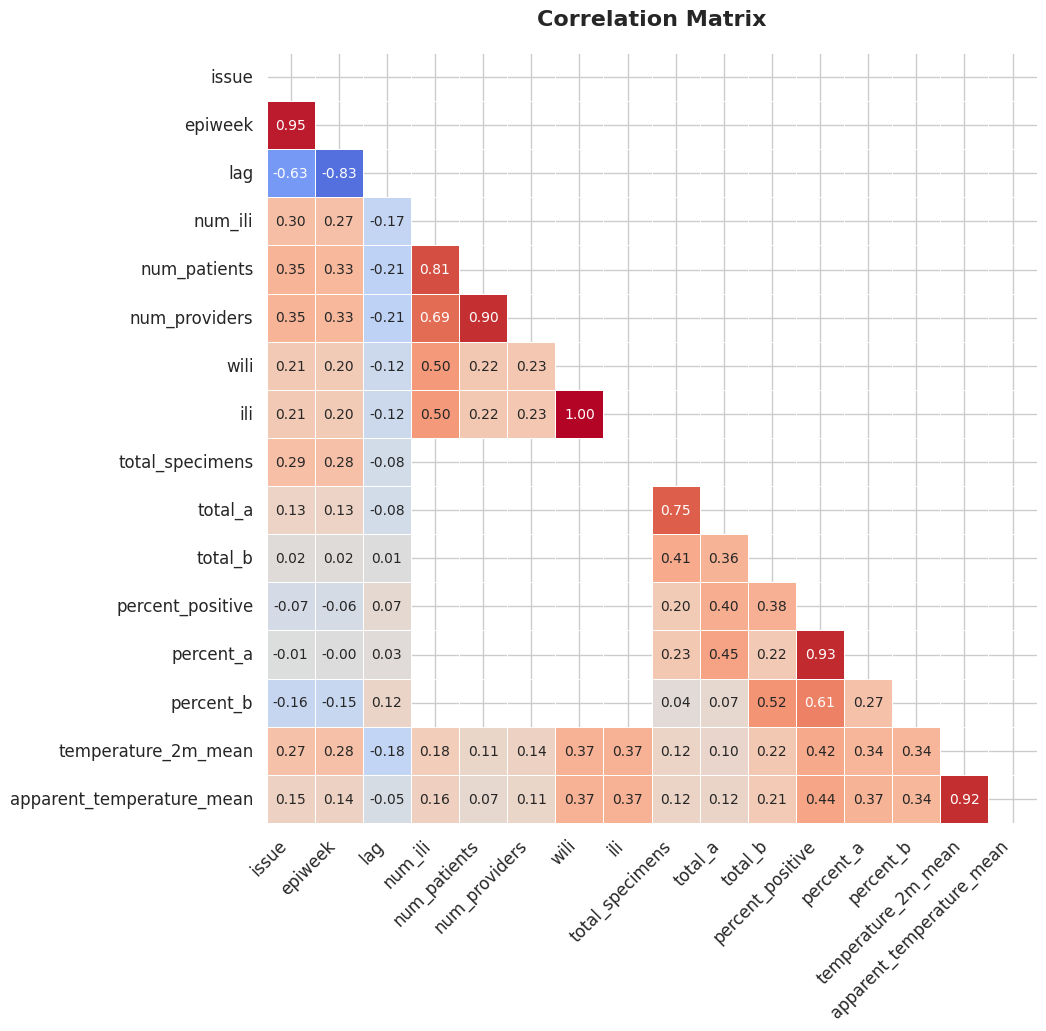

In [28]:
import numpy as np
plt.figure(figsize=(12, 10))

corr_matrix = df.select_dtypes(include='number').corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar=False,
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 10}
)

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", pad=20)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

plt.show()

El número de casos ILI y el reporte de influenza están fuertemente influenciados por factores de atención médica como:
* cantidad de pacientes atendidos
* número de proveedores de salud
* volumen de pruebas realizadas

Las tasas de positividad están más relacionadas con influenza tipo A.

Las temperaturas tienen una correlación débil a moderada con los indicadores epidemiológicos, lo que sugiere una posible estacionalidad, pero no una relación causal directa fuerte.

Multicolinealidad: Hay grupos de variables altamente correlacionadas (ili/wili, issue/epiweek, temperature_real/apparent) 

## Correlación de Variables

In [29]:
# Verificar que las columnas necesarias existen y no tienen valores nulos
df_filtered = df[['wili', 'temperature_2m_mean']].dropna()

# Calcular la correlación de Pearson
correlation = df_filtered.corr().iloc[0, 1]
correlation

np.float64(0.37234937469555524)

El coeficiente de correlación de Pearson es 0.37, lo que indica una correlación positiva moderada entre la incidencia de gripe (wili) y la temperatura media (temperature_2m_mean).

OBservaciones: 

A medida que la temperatura aumenta, wili tiende a aumentar ligeramente, pero la relación no es muy fuerte.

Esto sugiere que la temperatura podría influir en los casos de gripe, pero otros factores también son importantes

In [30]:
df = df[["wili", "state", "epiweek", "temperature_2m_mean", "num_ili", "num_providers"]].dropna()
df = df.reset_index(drop=True)
print(df.columns)

Index(['wili', 'state', 'epiweek', 'temperature_2m_mean', 'num_ili',
       'num_providers'],
      dtype='object')


In [32]:
df.head()

,wili,state,epiweek,temperature_2m_mean,num_ili,num_providers
0,0.875146,alaska,201040,26.262201,15.0,7.0
1,2.134770,alabama,201040,26.110119,249.0,35.0
2,0.696056,arkansas,201040,26.144941,18.0,15.0
3,0.674721,arizona,201040,26.202677,172.0,49.0
4,1.954120,california,201040,25.977680,632.0,112.0


In [33]:
df.tail()

,wili,state,epiweek,temperature_2m_mean,num_ili,num_providers
36635,4.68839,virginia,202511,26.585191,5734.0,196.0
36636,3.34992,washington,202511,26.625960,3515.0,153.0
36637,2.50078,wisconsin,202511,26.578201,721.0,61.0
36638,3.24351,west virginia,202511,26.583681,396.0,37.0
36639,3.35145,wyoming,202511,26.563224,74.0,11.0


### Outliers

In [ ]:
# Detecta valores atípicos (outliers) en todas las columnas numéricas utilizando el método IQR (Rango Intercuartílico) para identificarlos

def identify_outliers(df):

    outlier_info = {}

    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1 

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]  #Establece los límites inferior y superior para definir outliers según el criterio clásico del IQR.

        if not outliers.empty:
            outlier_info[col] = {
                'outliers_count': outliers.shape[0],
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outlier_values': outliers[col].tolist()
            }

    for col, info in outlier_info.items():
        print(f"Column: {col}")
        print(f"  Number of outliers: {info['outliers_count']}")
        print(f"  Low Limit: {info['lower_bound']}")
        print(f"  High Limit: {info['upper_bound']}")
        print(f"  Outliers: {info['outlier_values'][:5]}...\n")
    return outlier_info



In [35]:
outlier_info = identify_outliers(df)

Column: wili
  Number of outliers: 2484
  Low Limit: -1.8920743749999998
  High Limit: 4.918512625
  Outliers: [5.4632, 5.81097, 5.33836, 10.4359, 6.30401]...

Column: temperature_2m_mean
  Number of outliers: 62
  Low Limit: 23.683328625
  High Limit: 29.207145624999995
  Outliers: [23.142857, 23.57232, 23.58512, 23.508036, 23.568748]...

Column: num_ili
  Number of outliers: 3845
  Low Limit: -737.5
  High Limit: 1330.5
  Outliers: [1405.0, 1390.0, 1635.0, 1938.0, 1889.0]...

Column: num_providers
  Number of outliers: 2193
  Low Limit: -54.5
  High Limit: 133.5
  Outliers: [137.0, 139.0, 146.0, 147.0, 150.0]...



Column: wili
* Cualquier valor de wili superior a 4.92 se considera atípico.
* Esto sugiere que en muchas semanas hubo niveles anormalmente altos de visitas por ILI ponderadas, probablemente en temporadas epidémicas fuertes.

Column: temperature_2m_mean  
* los outliers están en el extremo bajo, cerca de 23°C.
* Esto sugiere que semanas con temperaturas inusualmente frías son poco comunes y se consideran atípicas.

Column: num_ili  
* Hay muchas semanas donde el número de casos ILI supera los 1,300, lo que se considera alto en comparación con la mayoría del dataset.
* Refleja temporadas fuertes de gripe o picos epidémicos, posiblemente localizados o estacionales.


In [41]:
# eliminar los valores atípicos (outliers) 

def remove_outliers(df, outlier_info):
    """ Remove outliers from the DataFrame based on the provided outlier information. """
    
    for col, info in outlier_info.items():
        if col == 'smoke' or col.startswith('region_'):
            continue
        lower_limit = info['lower_bound']
        upper_limit = info['upper_bound']
        
        if lower_limit < 0:
            df = df[df[col] >= lower_limit]
        if upper_limit > 0:
            df = df[df[col] <= upper_limit]

        
    return df

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36640 entries, 0 to 36639
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wili                  36640 non-null  float64
 1   epiweek               36640 non-null  int64  
 2   temperature_2m_mean   36640 non-null  float64
 3   num_ili               36640 non-null  float64
 4   num_providers         36640 non-null  float64
 5   state_alabama         36640 non-null  float64
 6   state_alaska          36640 non-null  float64
 7   state_arizona         36640 non-null  float64
 8   state_arkansas        36640 non-null  float64
 9   state_california      36640 non-null  float64
 10  state_colorado        36640 non-null  float64
 11  state_connecticut     36640 non-null  float64
 12  state_delaware        36640 non-null  float64
 13  state_florida         36640 non-null  float64
 14  state_georgia         36640 non-null  float64
 15  state_hawaii       

In [ ]:
#  transforma la columna categórica state en variables binarias
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
state_encoded = onehot_encoder.fit_transform(df[['state']]).toarray()

state_df = pd.DataFrame(state_encoded, columns=onehot_encoder.get_feature_names_out(['state']))

df = pd.concat([df.drop('state', axis=1), state_df], axis=1)

df.head()

In [44]:
df.to_csv('../data/processed/df_final.csv', index=False)

In [45]:
dataframe_without_outliers = remove_outliers(df, outlier_info)

dataframe_without_outliers.describe().round(2)

,wili,epiweek,temperature_2m_mean,num_ili,num_providers,state_alabama,state_alaska,state_arizona,state_arkansas,state_california,...,state_south dakota,state_tennessee,state_texas,state_utah,state_vermont,state_virginia,state_washington,state_west virginia,state_wisconsin,state_wyoming
count,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,...,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00,30856.00
mean,1.35,201736.53,26.34,226.91,35.74,0.02,0.02,0.02,0.02,0.01,...,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.02
std,1.03,409.03,0.92,286.57,27.65,0.13,0.15,0.15,0.15,0.12,...,0.15,0.14,0.12,0.15,0.15,0.09,0.15,0.15,0.15,0.15
min,0.00,201040.00,22.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.58,201405.00,25.68,29.00,15.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.10,201723.00,26.35,102.00,28.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.88,202106.00,27.05,317.00,48.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,4.92,202511.00,29.20,1330.00,133.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Implementación del Modelo

In [17]:
from sklearn.model_selection import train_test_split

def train_split(target, dataframe, test_size=0.2, random_state=42):
    """ Splits the DataFrame into training and testing sets."""
    return train_test_split(dataframe.drop(columns=target), dataframe[target], test_size=test_size, random_state=random_state)

In [16]:
from joblib import dump
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def standard_scaler(X_train, X_test, filename: str):

    """ Standardizes the features using StandardScaler and saves the scaler object."""

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_test_norm = scaler.transform(X_test)

    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, f'../data/processed/std_transform_{filename}.sav')

    return X_train_norm, X_test_norm

def min_max_scaler(X_train, X_test, reference: str):
    
    """ Scales the features using MinMaxScaler and saves the scaler object."""
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, f'../data/processed/minmax_{reference}.sav')

    return X_train_minmax, X_test_minmax


In [ ]:
TARGET = 'wili'

X_train_with_outliers, X_test_with_outliers, y_train, y_test = train_split(TARGET, df.copy())
X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers  = train_split(TARGET, dataframe_without_outliers)

#Default 
X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers_ts_02_rs_42.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers_ts_02_rs_42.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

#Without outliers
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers_ts_02_rs_42.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers_ts_02_rs_42.csv', index=False)

y_train_without_outliers.to_csv('../data/processed/y_train_without_outliers.csv', index=False)
y_test_without_outliers.to_csv('../data/processed/y_test_without_outliers.csv', index=False)

In [364]:
X_train_with_outliers_std, X_test_with_outliers_std = standard_scaler(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_std, X_test_without_outliers_std = standard_scaler(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

X_train_with_outliers_minmax, X_test_with_outliers_minmax = min_max_scaler(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = min_max_scaler(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

In [365]:
dfs_train = {
    'X_train_with_outliers': X_train_with_outliers,
    'X_train_with_outliers_std': X_train_with_outliers_std,
    'X_train_with_outliers_minmax': X_train_with_outliers_minmax,
}

dfs_train_without_outliers = {
    'X_train_without_outliers': X_train_without_outliers,
    'X_train_without_outliers_std': X_train_without_outliers_std,
    'X_train_without_outliers_minmax': X_train_without_outliers_minmax 
}

dfs_test = {
    'X_test_with_outliers': X_test_with_outliers,
    'X_test_with_outliers_std': X_test_with_outliers_std,
    'X_test_with_outliers_minmax': X_test_with_outliers_minmax,
}

dfs_test_without_outliers = {
    'X_test_without_outliers': X_test_without_outliers,
    'X_test_without_outliers_std': X_test_without_outliers_std,
    'X_test_without_outliers_minmax': X_test_without_outliers_minmax
}


for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

for name, df in dfs_train_without_outliers.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test_without_outliers.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

train = list(dfs_train.values())
test = list(dfs_test.values())
train_without_outliers = list(dfs_train_without_outliers.values())
test_without_outliers = list(dfs_test_without_outliers.values())

results = []

# Default
for index, train_df in enumerate(train):
    model = RandomForestRegressor(random_state=42)
    model.fit(train_df, y_train)
    y_pred = model.predict(test[index])
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })

# Without outliers
for index, train_df in enumerate(train_without_outliers):
    model = RandomForestRegressor(random_state=42)
    model.fit(train_df, y_train_without_outliers)
    y_pred = model.predict(test_without_outliers[index])
    mae = mean_absolute_error(y_test_without_outliers, y_pred)
    r2 = r2_score(y_test_without_outliers, y_pred)
    results.append({
        'index': index,
        'df_train': list(dfs_train_without_outliers.keys())[index],
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })


results = sorted(results, key=lambda x: x['r2'], reverse=True)
best_result = results[0]

print(f"Index: {best_result['index']}")
print(f"\ndf_train: {best_result['df_train']}")
print(f"MAE: {best_result['mae']}")
print(f"R2: {best_result['r2']}")
print(f"Y_pred: {best_result['y_pred'][:5]}...")

Index: 0

df_train: X_train_with_outliers
MAE: 0.22623563828065787
R2: 0.9363971941623198
Y_pred: [2.3380556  3.1655764  5.6770103  1.63642774 9.7555386 ]...


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],     
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],     
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='r2',  
                           cv=3,          
                           verbose=2,     
                           n_jobs=-1)     

best_results = []

# Default
for index, train_df in enumerate(train):
    grid_search.fit(train_df, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(test[index])

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    best_results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'best_params': grid_search.best_params_,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })

for index, train_df in enumerate(train_without_outliers):
    grid_search.fit(train_df, y_train_without_outliers)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(test_without_outliers[index])

    mae = mean_absolute_error(y_test_without_outliers, y_pred)
    r2 = r2_score(y_test_without_outliers, y_pred)

    best_results.append({
        'index': index,
        'df_train': list(dfs_train_without_outliers.keys())[index],
        'best_params': grid_search.best_params_,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })


best_results = sorted(best_results, key=lambda x: x['r2'], reverse=True)
best_model_result = best_results[0]

print(f"Index: {best_model_result['index']}")
print(f"df_train: {best_model_result['df_train']}")
print(f"Best Parameters: {best_model_result['best_params']}")
print(f"MAE: {best_model_result['mae']}")
print(f"R2: {best_model_result['r2']}")
print(f"Y_pred: {best_model_result['y_pred'][:5]}...")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  11.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  12.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  13.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  34.1s
[CV] END max_de

In [377]:
from joblib import dump
dump(best_model, '../models/best_random_forest_model.joblib')

['../models/best_random_forest_model.joblib']

In [ ]:
dataframe_without_states = df[['wili', 'temperature_2m_mean', 'num_ili', 'num_providers']].copy()

In [39]:
dataframe_without_outliers = remove_outliers(dataframe_without_states, outlier_info)

dataframe_without_outliers.describe().round(2)

,wili,temperature_2m_mean,num_ili,num_providers
count,30856.00,30856.00,30856.00,30856.00
mean,1.35,26.34,226.91,35.74
std,1.03,0.92,286.57,27.65
min,0.00,22.84,0.00,0.00
25%,0.58,25.68,29.00,15.00
50%,1.10,26.35,102.00,28.00
75%,1.88,27.05,317.00,48.00
max,4.92,29.20,1330.00,133.00


In [41]:
TARGET = 'wili'

X_train_without_states_with_outliers, X_test_without_states_with_outliers, y_without_states_train, y_without_states_test = train_split(TARGET, dataframe_without_states.copy())
X_train_without_states_without_outliers, X_test_without_states_without_outliers, y_train_without_states_without_outliers, y_test_without_states_without_outliers  = train_split(TARGET, dataframe_without_outliers)

#Default
X_train_without_states_with_outliers.to_csv('../data/processed/X_train_without_states_with_outliers_ts_02_rs_42.csv', index=False)
X_test_without_states_with_outliers.to_csv('../data/processed/X_test_without_states_with_outliers_ts_02_rs_42.csv', index=False)

y_without_states_train.to_csv('../data/processed/y_without_states_train.csv', index=False)
y_without_states_test.to_csv('../data/processed/y_without_states_test.csv', index=False)

#Without outliers
X_train_without_states_without_outliers.to_csv('../data/processed/X_train_without_states_without_outliers_ts_02_rs_42.csv', index=False)
X_test_without_states_without_outliers.to_csv('../data/processed/X_test_without_states_without_outliers_ts_02_rs_42.csv', index=False)

y_train_without_states_without_outliers.to_csv('../data/processed/y_train_without_states_without_outliers.csv', index=False)
y_test_without_states_without_outliers.to_csv('../data/processed/y_test_without_states_without_outliers.csv', index=False)

In [44]:
X_train_without_states_with_outliers_std, X_test_without_states_with_outliers_std = standard_scaler(X_train_without_states_with_outliers, X_test_without_states_with_outliers, 'with_outliers')
X_train_without_states_without_outliers_std, X_test_without_states_without_outliers_std = standard_scaler(X_train_without_states_without_outliers, X_test_without_states_without_outliers, 'without_outliers')

X_train_without_states_with_outliers_minmax, X_test_without_states_with_outliers_minmax = min_max_scaler(X_train_without_states_with_outliers, X_test_without_states_with_outliers, 'with_outliers')
X_train_without_states_without_outliers_minmax, X_test_without_states_without_outliers_minmax = min_max_scaler(X_train_without_states_without_outliers, X_test_without_states_without_outliers, 'without_outliers')

In [45]:
dfs_train = {
    'X_train_without_states_with_outliers': X_train_without_states_with_outliers,
    'X_train_without_states_with_outliers_std': X_train_without_states_with_outliers_std,
    'X_train_without_states_with_outliers_minmax': X_train_without_states_with_outliers_minmax,
}

dfs_train_without_outliers = {
    'X_train_without_states_without_outliers': X_train_without_states_without_outliers,
    'X_train_without_states_without_outliers_std': X_train_without_states_without_outliers_std,
    'X_train_without_states_without_outliers_minmax': X_train_without_states_without_outliers_minmax 
}

dfs_test = {
    'X_test_without_states_with_outliers': X_test_without_states_with_outliers,
    'X_test_without_states_with_outliers_std': X_test_without_states_with_outliers_std,
    'X_test_without_states_with_outliers_minmax': X_test_without_states_with_outliers_minmax,
}

dfs_test_without_outliers = {
    'X_test_without_states_without_outliers': X_test_without_states_without_outliers,
    'X_test_without_states_without_outliers_std': X_test_without_states_without_outliers_std,
    'X_test_without_states_without_outliers_minmax': X_test_without_states_without_outliers_minmax
}


for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

for name, df in dfs_train_without_outliers.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test_without_outliers.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

train = list(dfs_train.values())
test = list(dfs_test.values())
train_without_outliers = list(dfs_train_without_outliers.values())
test_without_outliers = list(dfs_test_without_outliers.values())

results = []

# Default
for index, train_df in enumerate(train):
    model = RandomForestRegressor(random_state=42)
    model.fit(train_df, y_train)
    y_pred = model.predict(test[index])
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })

# Without outliers
for index, train_df in enumerate(train_without_outliers):
    model = RandomForestRegressor(random_state=42)
    model.fit(train_df, y_train_without_outliers)
    y_pred = model.predict(test_without_outliers[index])
    mae = mean_absolute_error(y_test_without_outliers, y_pred)
    r2 = r2_score(y_test_without_outliers, y_pred)
    results.append({
        'index': index,
        'df_train': list(dfs_train_without_outliers.keys())[index],
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })


results = sorted(results, key=lambda x: x['r2'], reverse=True)
best_result = results[0]

print(f"Index: {best_result['index']}")
print(f"\ndf_train: {best_result['df_train']}")
print(f"MAE: {best_result['mae']}")
print(f"R2: {best_result['r2']}")
print(f"Y_pred: {best_result['y_pred'][:5]}...")

Index: 2

df_train: X_train_without_states_with_outliers_minmax
MAE: 0.5260438581303138
R2: 0.7665936217592626
Y_pred: [2.2172845  3.21581385 5.3495553  1.68580192 9.9725687 ]...


In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],     
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],     
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='r2',  
                           cv=3,          
                           verbose=2,     
                           n_jobs=-1)     

best_results = []

# Default
for index, train_df in enumerate(train):
    grid_search.fit(train_df, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(test[index])

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    best_results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'best_params': grid_search.best_params_,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })

for index, train_df in enumerate(train_without_outliers):
    grid_search.fit(train_df, y_train_without_outliers)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(test_without_outliers[index])

    mae = mean_absolute_error(y_test_without_outliers, y_pred)
    r2 = r2_score(y_test_without_outliers, y_pred)

    best_results.append({
        'index': index,
        'df_train': list(dfs_train_without_outliers.keys())[index],
        'best_params': grid_search.best_params_,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })


best_results = sorted(best_results, key=lambda x: x['r2'], reverse=True)
best_model_result = best_results[0]

print(f"Index: {best_model_result['index']}")
print(f"df_train: {best_model_result['df_train']}")
print(f"Best Parameters: {best_model_result['best_params']}")
print(f"MAE: {best_model_result['mae']}")
print(f"R2: {best_model_result['r2']}")
print(f"Y_pred: {best_model_result['y_pred'][:5]}...")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   7.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  14.0s
[CV] END max_de

In [24]:
dataframe = pd.read_csv('../data/processed/df_final.csv', delimiter=',', encoding='utf-8')
dataframe.head()

,wili,epiweek,temperature_2m_mean,num_ili,num_providers,state_alabama,state_alaska,state_arizona,state_arkansas,state_california,...,state_south dakota,state_tennessee,state_texas,state_utah,state_vermont,state_virginia,state_washington,state_west virginia,state_wisconsin,state_wyoming
0,0.875146,201040,26.262201,15.0,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.134770,201040,26.110119,249.0,35.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.696056,201040,26.144941,18.0,15.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.674721,201040,26.202677,172.0,49.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.954120,201040,25.977680,632.0,112.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
state_to_hhs = {
    "state_alabama": "HHS4", "state_alaska": "HHS10", "state_arizona": "HHS9", "state_arkansas": "HHS6",
    "state_california": "HHS9", "state_colorado": "HHS8", "state_connecticut": "HHS1", "state_delaware": "HHS3",
    "state_florida": "HHS4", "state_georgia": "HHS4", "state_hawaii": "HHS9", "state_idaho": "HHS10",
    "state_illinois": "HHS5", "state_indiana": "HHS5", "state_iowa": "HHS7", "state_kansas": "HHS7",
    "state_kentucky": "HHS4", "state_louisiana": "HHS6", "state_maine": "HHS1", "state_maryland": "HHS3",
    "state_massachusetts": "HHS1", "state_michigan": "HHS5", "state_minnesota": "HHS5", "state_mississippi": "HHS4",
    "state_missouri": "HHS7", "state_montana": "HHS8", "state_nebraska": "HHS7", "state_nevada": "HHS9",
    "state_new hampshire": "HHS1", "state_new jersey": "HHS2", "state_new mexico": "HHS6", "state_new york": "HHS2",
    "state_north carolina": "HHS4", "state_north dakota": "HHS8", "state_ohio": "HHS5", "state_oklahoma": "HHS6",
    "state_oregon": "HHS10", "state_pennsylvania": "HHS3", "state_rhode island": "HHS1", "state_south carolina": "HHS4",
    "state_south dakota": "HHS8", "state_tennessee": "HHS4", "state_texas": "HHS6", "state_utah": "HHS8",
    "state_vermont": "HHS1", "state_virginia": "HHS3", "state_washington": "HHS10", "state_west virginia": "HHS3",
    "state_wisconsin": "HHS5", "state_wyoming": "HHS8"
}

def map_region(row):
    for state, region in state_to_hhs.items():
        if row[state] == 1:
            return region
    return None

dataframe["region"] = dataframe.apply(map_region, axis=1)

hhs_regions = {
    "HHS1": "Región 1", "HHS2": "Región 2", "HHS3": "Región 3", "HHS4": "Región 4",
    "HHS5": "Región 5", "HHS6": "Región 6", "HHS7": "Región 7", "HHS8": "Región 8",
    "HHS9": "Región 9", "HHS10": "Región 10"
}

state_columns = [col for col in dataframe.columns if col.startswith("state_")]
dataframe.drop(columns=state_columns, inplace=True)

print(dataframe.head())

       wili  epiweek  temperature_2m_mean  num_ili  num_providers region
0  0.875146   201040            26.262201     15.0            7.0  HHS10
1  2.134770   201040            26.110119    249.0           35.0   HHS4
2  0.696056   201040            26.144941     18.0           15.0   HHS6
3  0.674721   201040            26.202677    172.0           49.0   HHS9
4  1.954120   201040            25.977680    632.0          112.0   HHS9


In [27]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
state_encoded = onehot_encoder.fit_transform(dataframe[['region']]).toarray()

state_df = pd.DataFrame(state_encoded, columns=onehot_encoder.get_feature_names_out(['region']))

dataframe = pd.concat([dataframe.drop('region', axis=1), state_df], axis=1)

dataframe.head()

,wili,epiweek,temperature_2m_mean,num_ili,num_providers,region_HHS1,region_HHS10,region_HHS2,region_HHS3,region_HHS4,region_HHS5,region_HHS6,region_HHS7,region_HHS8,region_HHS9
0,0.875146,201040,26.262201,15.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.134770,201040,26.110119,249.0,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.696056,201040,26.144941,18.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.674721,201040,26.202677,172.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.954120,201040,25.977680,632.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
TARGET = 'wili'

X_train_with_regions_with_outliers, X_test_with_regions_with_outliers, y_with_regions_train, y_with_regions_test = train_split(TARGET, dataframe.copy())
X_train_with_regions_without_outliers, X_test_with_regions_without_outliers, y_train_with_regions_without_outliers, y_test_with_regions_without_outliers  = train_split(TARGET, dataframe)

#Default
X_train_with_regions_with_outliers.to_csv('../data/processed/X_train_with_regions_with_outliers_ts_02_rs_42.csv', index=False)
X_test_with_regions_with_outliers.to_csv('../data/processed/X_test_with_regions_with_outliers_ts_02_rs_42.csv', index=False)

y_with_regions_train.to_csv('../data/processed/y_with_regions_train.csv', index=False)
y_with_regions_test.to_csv('../data/processed/y_with_regions_test.csv', index=False)

#Without outliers
X_train_with_regions_without_outliers.to_csv('../data/processed/X_train_with_regions_without_outliers_ts_02_rs_42.csv', index=False)
X_test_with_regions_without_outliers.to_csv('../data/processed/X_test_with_regions_without_outliers_ts_02_rs_42.csv', index=False)

y_train_with_regions_without_outliers.to_csv('../data/processed/y_train_with_regions_without_outliers.csv', index=False)
y_test_with_regions_without_outliers.to_csv('../data/processed/y_test_with_regions_without_outliers.csv', index=False)

In [29]:
X_train_with_regions_with_outliers_std, X_test_with_regions_with_outliers_std = standard_scaler(X_train_with_regions_with_outliers, X_test_with_regions_with_outliers, 'with_outliers')
X_train_with_regions_without_outliers_std, X_test_with_regions_without_outliers_std = standard_scaler(X_train_with_regions_without_outliers, X_test_with_regions_without_outliers, 'without_outliers')

X_train_with_regions_with_outliers_minmax, X_test_with_regions_with_outliers_minmax = min_max_scaler(X_train_with_regions_with_outliers, X_test_with_regions_with_outliers, 'with_outliers')
X_train_with_regions_without_outliers_minmax, X_test_with_regions_without_outliers_minmax = min_max_scaler(X_train_with_regions_without_outliers, X_test_with_regions_without_outliers, 'without_outliers')

In [30]:
dfs_train = {
    'X_train_with_regions_with_outliers': X_train_with_regions_with_outliers,
    'X_train_with_regions_with_outliers_std': X_train_with_regions_with_outliers_std,
    'X_train_with_regions_with_outliers_minmax': X_train_with_regions_with_outliers_minmax,
}

dfs_train_without_outliers = {
    'X_train_with_regions_without_outliers': X_train_with_regions_without_outliers,
    'X_train_with_regions_without_outliers_std': X_train_with_regions_without_outliers_std,
    'X_train_with_regions_without_outliers_minmax': X_train_with_regions_without_outliers_minmax 
}

dfs_test = {
    'X_test_with_regions_with_outliers': X_test_with_regions_with_outliers,
    'X_test_with_regions_with_outliers_std': X_test_with_regions_with_outliers_std,
    'X_test_wwith_regions_with_outliers_minmax': X_test_with_regions_with_outliers_minmax,
}

dfs_test_without_outliers = {
    'X_test_with_regions_without_outliers': X_test_with_regions_without_outliers,
    'X_test_with_regions_without_outliers_std': X_test_with_regions_without_outliers_std,
    'X_test_with_regions_without_outliers_minmax': X_test_with_regions_without_outliers_minmax
}


for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

for name, df in dfs_train_without_outliers.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test_without_outliers.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

train = list(dfs_train.values())
test = list(dfs_test.values())
train_without_outliers = list(dfs_train_without_outliers.values())
test_without_outliers = list(dfs_test_without_outliers.values())

results = []

# Default
for index, train_df in enumerate(train):
    model = RandomForestRegressor(random_state=42)
    model.fit(train_df, y_with_regions_train)
    y_pred = model.predict(test[index])
    mae = mean_absolute_error(y_with_regions_test, y_pred)
    r2 = r2_score(y_with_regions_test, y_pred)
    results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })

# Without outliers
for index, train_df in enumerate(train_without_outliers):
    model = RandomForestRegressor(random_state=42)
    model.fit(train_df, y_train_with_regions_without_outliers)
    y_pred = model.predict(test_without_outliers[index])
    mae = mean_absolute_error(y_test_with_regions_without_outliers, y_pred)
    r2 = r2_score(y_test_with_regions_without_outliers, y_pred)
    results.append({
        'index': index,
        'df_train': list(dfs_train_without_outliers.keys())[index],
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })


results = sorted(results, key=lambda x: x['r2'], reverse=True)
best_result = results[0]

print(f"Index: {best_result['index']}")
print(f"\ndf_train: {best_result['df_train']}")
print(f"MAE: {best_result['mae']}")
print(f"R2: {best_result['r2']}")
print(f"Y_pred: {best_result['y_pred'][:5]}...")

Index: 1

df_train: X_train_with_regions_with_outliers_std
MAE: 0.2860987941376395
R2: 0.9069812442895069
Y_pred: [2.6499317  3.16736905 4.9459118  1.64707047 9.8799452 ]...


In [44]:
X_train_with_regions_with_outliers_std.columns

Index(['epiweek', 'temperature_2m_mean', 'num_ili', 'num_providers',
       'region_HHS1', 'region_HHS10', 'region_HHS2', 'region_HHS3',
       'region_HHS4', 'region_HHS5', 'region_HHS6', 'region_HHS7',
       'region_HHS8', 'region_HHS9'],
      dtype='object')

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],     
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],     
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='r2',  
                           cv=3,          
                           verbose=2,     
                           n_jobs=-1)     

best_results = []

# Default
for index, train_df in enumerate(train):
    grid_search.fit(train_df, y_with_regions_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(test[index])

    mae = mean_absolute_error(y_with_regions_test, y_pred)
    r2 = r2_score(y_with_regions_test, y_pred)

    best_results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'best_params': grid_search.best_params_,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })

for index, train_df in enumerate(train_without_outliers):
    grid_search.fit(train_df, y_train_with_regions_without_outliers)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(test_without_outliers[index])

    mae = mean_absolute_error(y_test_with_regions_without_outliers, y_pred)
    r2 = r2_score(y_test_with_regions_without_outliers, y_pred)

    best_results.append({
        'index': index,
        'df_train': list(dfs_train_without_outliers.keys())[index],
        'best_params': grid_search.best_params_,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred
    })


best_results = sorted(best_results, key=lambda x: x['r2'], reverse=True)
best_model_result = best_results[0]

print(f"Index: {best_model_result['index']}")
print(f"df_train: {best_model_result['df_train']}")
print(f"Best Parameters: {best_model_result['best_params']}")
print(f"MAE: {best_model_result['mae']}")
print(f"R2: {best_model_result['r2']}")
print(f"Y_pred: {best_model_result['y_pred'][:5]}...")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 422, in _on_run
    cmd.send(self.sock)
  File "/home/vscode/.local/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_net_command.py", line 111, in send
    sock.sendall(("Content-Length: %s\r\n\r\n" % len(as_bytes)).encode("ascii"))
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py", line 53, in run
    self._on_run()
  File "/home/vscode/.local/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 432, in _on_run
    self.py_db.dispose_and_kill_all_pydevd_threads()
  File "/home/vscode/.local/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydevd.py", li

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  22.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators

In [43]:
from joblib import dump
dump(best_model, '../models/best_random_forest_model_with_regions.joblib')

['../models/best_random_forest_model_with_regions.joblib']

In [ ]:
simulation_data_extended = pd.DataFrame({
    "epiweek": np.random.choice(range(201040, 202540), 15),
    "temperature_2m_mean": np.random.uniform(20, 30, 15),    
    "num_ili": np.random.choice([5, 50, 100, 500, 1000], 15),
    "num_providers": np.random.choice([1, 10, 50, 100], 15), 
    "region_HHS1": np.random.choice([0, 1], 15),             
    "region_HHS10": np.random.choice([0, 1], 15),
    "region_HHS2": np.random.choice([0, 1], 15),
    "region_HHS3": np.random.choice([0, 1], 15),
    "region_HHS4": np.random.choice([0, 1], 15),
    "region_HHS5": np.random.choice([0, 1], 15),
    "region_HHS6": np.random.choice([0, 1], 15),
    "region_HHS7": np.random.choice([0, 1], 15),
    "region_HHS8": np.random.choice([0, 1], 15),
    "region_HHS9": np.random.choice([0, 1], 15),
})

for col in X_train_with_regions_with_outliers_std.columns:
    if col not in simulation_data_extended.columns:
        simulation_data_extended[col] = 0

simulated_predictions_extended = best_model.predict(simulation_data_extended)

simulation_data_extended["wili_predicted"] = simulated_predictions_extended

print(simulation_data_extended)

    epiweek  temperature_2m_mean  num_ili  num_providers  region_HHS1  \
0    201231            21.557356     1000              1            1   
1    201568            27.911715     1000             10            0   
2    202048            20.644543        5             10            1   
3    202274            24.910602     1000            100            0   
4    201476            20.694986      500              1            0   
5    202167            26.149641     1000            100            1   
6    201256            22.944103      500              1            0   
7    202212            21.956092       50              1            0   
8    202335            25.852357     1000             10            1   
9    201790            21.217333      100            100            1   
10   202041            21.721983       50             10            1   
11   201116            26.120254      100            100            0   
12   201406            21.804286      500          

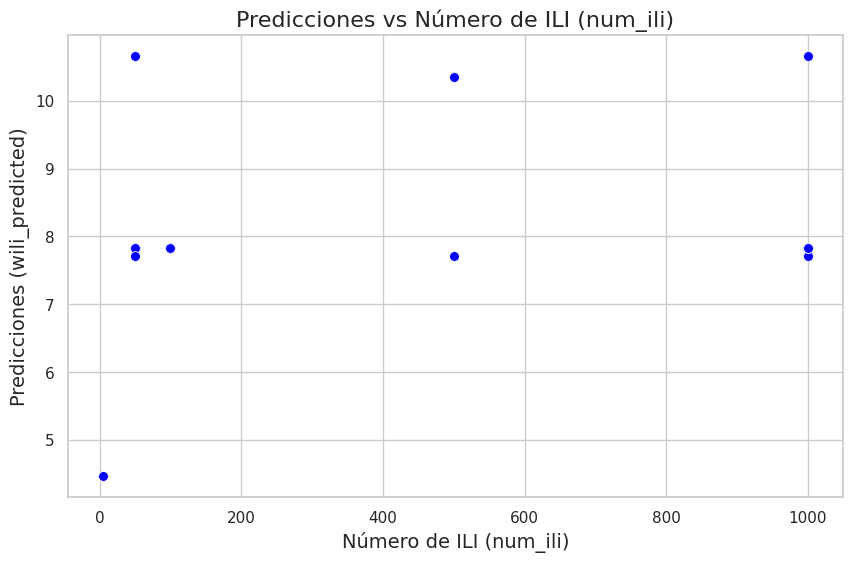

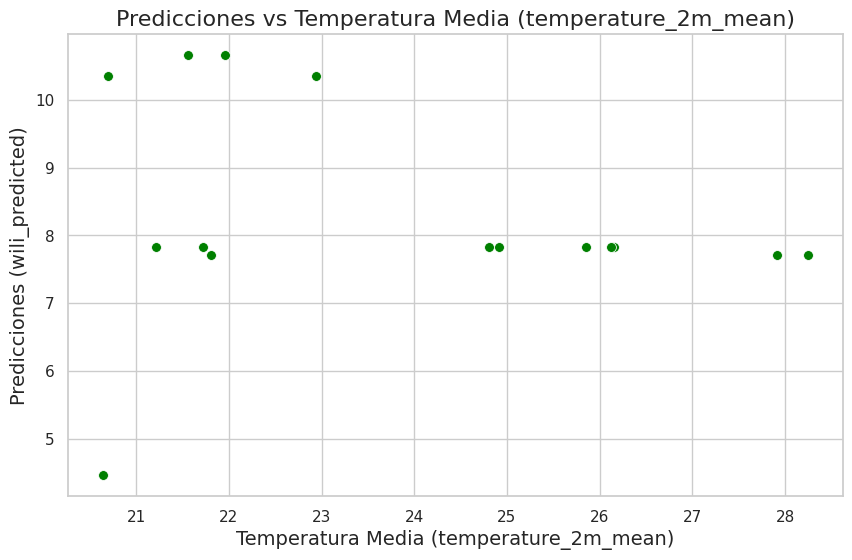

In [51]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_ili', y='wili_predicted', data=simulation_data_extended, color='blue', s=50)
plt.title('Predicciones vs Número de ILI (num_ili)', fontsize=16)
plt.xlabel('Número de ILI (num_ili)', fontsize=14)
plt.ylabel('Predicciones (wili_predicted)', fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature_2m_mean', y='wili_predicted', data=simulation_data_extended, color='green', s=50)
plt.title('Predicciones vs Temperatura Media (temperature_2m_mean)', fontsize=16)
plt.xlabel('Temperatura Media (temperature_2m_mean)', fontsize=14)
plt.ylabel('Predicciones (wili_predicted)', fontsize=14)
plt.show()

# Análisis de Gráficos de Predicción

## 1. Relación entre `wili_predicted` y `num_ili`
El primer gráfico muestra cómo las predicciones del modelo (`wili_predicted`) varían en función del número de casos reportados de ILI (`num_ili`). Se observa una tendencia clara: a medida que aumenta el número de ILI, las predicciones también tienden a incrementarse. Esto tiene sentido ya que `num_ili` es la característica con mayor influencia en el modelo según el análisis de importancia de características. El gráfico sugiere una correlación positiva directa, lo que refuerza la importancia de esta variable en la capacidad predictiva del modelo.

### Detalles:
- El eje x representa el número de casos de ILI (`num_ili`).
- El eje y muestra las predicciones del modelo (`wili_predicted`).
- Los puntos distribuidos revelan cómo el modelo responde de manera consistente a cambios en esta característica clave.

## 2. Relación entre `wili_predicted` y `temperature_2m_mean`
El segundo gráfico visualiza la relación entre las predicciones del modelo (`wili_predicted`) y la temperatura media (`temperature_2m_mean`). Aunque la correlación no es tan marcada como en el caso anterior, se nota una ligera variación en las predicciones según los diferentes valores de temperatura. Esto sugiere que la temperatura podría tener un efecto moderado o indirecto en los resultados del modelo. Este gráfico podría ser útil para explorar interacciones más complejas entre la temperatura y otras variables relevantes.

### Detalles:
- El eje x representa la temperatura media (`temperature_2m_mean`).
- El eje y muestra las predicciones del modelo (`wili_predicted`).
- Los puntos verdes están dispersos, lo que indica que el impacto de la temperatura en las predicciones podría no ser lineal.

### Conclusión:
Ambos gráficos ofrecen una representación clara y útil del comportamiento del modelo y cómo las variables de entrada afectan las predicciones. Estas visualizaciones son esenciales para respaldar las interpretaciones y conclusiones derivadas del análisis. Además, destacan la eficacia del modelo en responder a variaciones significativas en las características clave.


In [42]:
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X_train_with_regions_with_outliers_std.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
print(importance_df)

                Feature  Importance
2               num_ili    0.570204
3         num_providers    0.251302
0               epiweek    0.065680
1   temperature_2m_mean    0.039514
11          region_HHS7    0.015828
10          region_HHS6    0.012511
13          region_HHS9    0.010459
12          region_HHS8    0.007521
8           region_HHS4    0.006662
6           region_HHS2    0.006459
7           region_HHS3    0.004086
4           region_HHS1    0.003884
9           region_HHS5    0.003806
5          region_HHS10    0.002082
